For faster development speed, type `Ctrl + M, H` to view Google Colab keyboard shortcuts.

### Getting Started


#### Mounting your Google Drive

In [101]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import feature_selection
import sklearn.preprocessing
from sklearn import metrics

In [2]:
from google.colab import drive

"""Running this cell will generate a message asking you 
to click on a link where you'll obtain an authorization code.

Paste that authorization code into the text box that appears below.
"""
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!cd "/content/gdrive/MyDrive/" && ls # Displays directories in MyDrive/

 ApTSi		    Education	'School-Related Planning'   地位を申し込む
'Colab Notebooks'   Other	 SCIP
 Data		    Recordings	 temp


In [4]:
dir_path = os.path.join("/content/gdrive/MyDrive/Data", "NNsforGenomics")
os.path.exists(dir_path)

True

In [5]:
!cd {dir_path} && ls

ctgan  data  ml_models.py  neural_networks.py  preprocessing.py  __pycache__


In [6]:
import sys
sys.path.append(dir_path)
data_path = os.path.join(dir_path, "data")


In [7]:
import ctgan 
import preprocessing
import ml_models
import neural_networks

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [8]:
pp = preprocessing.Preprocessing()
Y, names = pp.get_Y(data_path=data_path)
X = pd.read_csv(os.path.join(data_path, "X.csv"))

In [9]:
X.shape, Y.shape

((4061, 25869), (4061, 1))

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4061 entries, 0 to 4060
Columns: 25869 entries, chr5.32745853 to chr17.38364472
dtypes: float64(25869)
memory usage: 801.5 MB


In [11]:
X.values

array([[0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [12]:
X.describe()

,chr5.32745853,chr2.149849943,chr5.82690803,chr1.53574431,chr5.17456949,chr2.16908413,chr5.101199272,chr6.87974476,chr1.145668041,chr2.128289333,chr8.55456863,chr16.57579492,chr3.171581928,chr3.146346938,chr11.4956178,chr10.76495410,chr4.66467903,chr3.118922000,chr6.49826396,chr6.52647731,chr15.45004024,chr17.76466409,chr18.16976343,chr12.26514331,chr2.45201538,chr13.71570078,chr15.94670186,chr5.169760208,chr2.26057623,chr3.87933394,chr15.39337568,chr8.38082142,chr3.61930186,chr7.133818582,chr1.176679587,chr1.113308067,chr14.111487418,chr6.36112155,chr20.19654001,chr19.11525760,...,chr7.119977570,chr15.56870663,chr14.112196834,chr4.132265658,chr7.125708822,chr10.47433609,chr18.74608063,chr17.5080971,chr14.39366460,chr19.30358965,chr15.30841673,chr11.61819007,chr1.231581487,chr6.105424335,chr13.53558295,chr15.46605240,chr11.26627375,chr8.12542048,chr4.146868806,chr1.125270544,chr1.153848414,chr18.12304992,chr9.112665146,chr13.56615454,chr6.130328526,chr8.17722261,chr8.59962351,chr5.138885511,chr8.72868651,chr1.130970243,chr17.79903024,chr11.3180079,chr13.69847004,chr1.88863543,chr1.112074978,chr6.41497792,chr5.101909804,chr1.229171454,chr6.4991602,chr17.38364472
count,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.00000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,...,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000
mean,0.438316,0.057621,0.355331,0.839448,0.964295,0.720758,0.852992,0.489042,0.173603,0.580153,0.375031,0.919724,0.667077,0.847821,0.796109,0.916769,0.155380,0.564885,0.101699,1.020438,0.246737,0.661167,0.612903,0.456045,0.218665,0.527703,0.718788,0.78626,0.878355,0.980793,0.574982,0.055898,0.400148,0.278749,0.166954,0.604777,0.375523,0.373800,0.291061,0.559961,...,0.443979,0.330460,0.714602,0.660428,0.891160,0.151194,0.430928,0.031027,0.833292,0.430190,0.058360,0.170648,0.336124,0.675696,0.504802,0.799557,0.703768,0.942871,0.555036,0.922433,0.875893,0.048018,0.173110,0.360995,0.359025,0.262251,0.939670,1.034721,0.039153,0.777395,0.516622,0.823196,0.753263,0.676188,0.825412,0.278010,0.839448,0.540261,0.505294,0.119921
std,0.645522,0.233055,0.598491,0.917445,0.863294,0.789921,0.960967,0.675898,0.419538,0.682498,0.590947,0.878847,0.782488,0.707795,0.930223,0.863586,0.362991,0.646353,0.308739,0.875685,0.493497,0.800518,0.810869,0.659042,0.457511,0.652795,0.877027,0.79352,0.902911,0.764434,0.709960,0.235051,0.571223,0.549172,0.411295,0.768638,0.625077,0.560738,0.527557,0.704778,...,0.655501,0.573753,0.704004,0.823714,0.870973,0.386715,0.669879,0.173412,0.733461,0.662407,0.234452,0.406457,0.564157,0.670984,0.635012,0.918453,0.828470,0.894805,0.730569,0.846983,0.822625,0.216122,0.414427,0.610011,0.627479,0.509927,0.774949,0.749401,0.196506,0.841176,0.733459,0.944397,0.818019,0.691822,0.947543,0.509788,0.952999,0.741565,0.721782,0.342620
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.

In [13]:
chi2 = feature_selection.chi2
selectk = feature_selection.SelectKBest(chi2, k=100)
X_r = selectk.fit_transform(X.values, Y.flatten())
X_r.shape

(4061, 100)

In [14]:
print(torch.cuda.device_count()) # number of GPU devices available
print(torch.cuda.get_device_name(0)) # name of device
device = torch.device('cuda:0') # sets the device to the cuda at index 0
device

1
Tesla T4


device(type='cuda', index=0)

In [15]:
ml = ml_models.ML(X_r, Y)
ml.trainGANs()

In [40]:
X_fake, Y_fake = ml.getFakeSamples(n = 2000)
Y_fake = np.around(Y_fake).astype(int)
scaler = sklearn.preprocessing.MinMaxScaler()
X_fake = scaler.fit_transform(X_fake)

In [41]:
constants = neural_networks.NNConstants(BATCH_SIZE=100, D_OUT=3, X=X_fake)
ffnn = neural_networks.FFNN(X_fake, Y_fake, constants)
ffnn.device = device
network = ffnn.network
ffnn.network.to(device)
print(network)

Architecture(
  (fc_in): Linear(in_features=100, out_features=66, bias=True)
  (fc_h0): Linear(in_features=66, out_features=33, bias=True)
  (fc_out): Linear(in_features=33, out_features=3, bias=True)
)


Epoch: 0, Training Loss: 8.728, Validation loss: 3.295
Epoch: 1, Training Loss: 8.425, Validation loss: 3.333
Epoch: 2, Training Loss: 8.251, Validation loss: 3.162
Epoch: 3, Training Loss: 7.982, Validation loss: 3.263
Epoch: 4, Training Loss: 7.861, Validation loss: 3.378
Epoch: 5, Training Loss: 7.685, Validation loss: 3.319
Epoch: 6, Training Loss: 7.514, Validation loss: 3.323
Epoch: 7, Training Loss: 7.316, Validation loss: 3.517
Epoch: 8, Training Loss: 7.162, Validation loss: 3.470
Epoch: 9, Training Loss: 6.850, Validation loss: 3.677
Epoch: 10, Training Loss: 6.617, Validation loss: 3.917
Epoch: 11, Training Loss: 6.455, Validation loss: 3.857
Epoch: 12, Training Loss: 6.225, Validation loss: 3.897
Epoch: 13, Training Loss: 6.100, Validation loss: 3.995
Epoch: 14, Training Loss: 6.052, Validation loss: 3.964
Epoch: 15, Training Loss: 5.756, Validation loss: 4.263
Epoch: 16, Training Loss: 5.755, Validation loss: 4.614
Epoch: 17, Training Loss: 5.177, Validation loss: 4.951
Ep

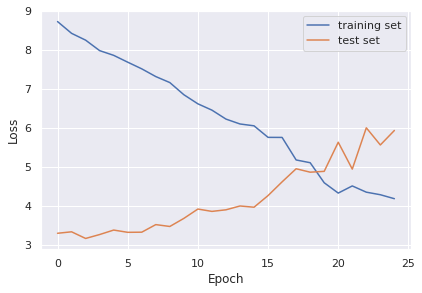

In [46]:
ffnn = neural_networks.FFNN(X_fake, Y_fake, constants)
ffnn.device = device
ffnn.network.to(device)
ffnn.train(n_epochs=25)

In [87]:
ffnn.network(torch.Tensor(ml.X_test).to(device))

tensor([[-9.0524e+00, -4.3365e+00, -1.3287e-02],
        [-4.0477e-01, -1.1300e+00, -4.6201e+00],
        [-8.6785e+00, -2.4319e-02, -3.7357e+00],
        ...,
        [-1.2876e+01, -5.4182e+00, -4.4476e-03],
        [-8.5230e-01, -5.8263e-01, -4.1906e+00],
        [-8.2199e-01, -6.4317e-01, -3.3576e+00]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)

In [113]:
def predict(input: np.ndarray, network) -> np.ndarray:
    input = torch.Tensor(input).to(device)
    output = network(input).cpu().detach().numpy().argmax(axis = 1)
    return output
def accuracy(Y, Y_pred):
    Y_pred, Y = [y.flatten() for y in [Y_pred, Y]]
    right, wrong = pd.Series(Y_pred == Y).value_counts()
    return right / (right + wrong)


predict(ml.X_test, ffnn.network)

array([2, 0, 1, ..., 2, 1, 1])

In [97]:
predict(X_fake, ffnn.network).shape, Y_fake.shape

((1000,), (1000,))

In [114]:
output = predict(ml.X_test, ffnn.network)
print(f"Accuracy: {accuracy(ml.Y_test, output):.4f}")

Accuracy: 0.5719


In [124]:
accuracy(Y_fake, predict(X_fake, ffnn.network))

0.68

In [129]:
accuracy(ml.Y_test, predict(ml.X_test, ffnn.network))

0.5718503937007874

In [130]:
accuracy(ml.Y_train, predict(ml.X_train, ffnn.network))

0.5924466338259442